# **Slumage**
**Jupyter notebook développé pour le pre-processing des images Sentinel-2 et Sentinel-1 pour les utiliser plus tard dans un modèle deep learning.** Ce notebook a été réalisé par Julien Govoorts dans le cardre d'un stage au sein de l'ANAGEO (IGEAT-ULB) pour le cours de STAG-F026 au sein du master en sciences et gestion de l'environnement à finalité sciences de l'environnement. Ce notebook utilise des données Sentinel-1 et 2 dans le but, dans un second temps, de cartographier (selon une probabilité) à partir d'un modèle deep learning les bidonvilles dans Nairobi (Kenya). 

Auteurs : Julien Govoorts et Taïs Grippa

## **Import libraries**

In [1]:
from osgeo import gdal
from osgeo import ogr
import os, sys
import numpy as np
import json
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import h5py

In [4]:
import numpy as np 
from cv2 import cvtColor, COLOR_BGR2RGB
	
def Norma_Xpercentile(image_data, prct:int = 2, BGR2RGB=True):
	'''
	Function that perform x percent histogram equalization of RGB images display
	'''

	a = np.ndarray(image_data.shape, dtype='float32')  
	a[:,:,0] = (image_data[:,:,0] - np.nanpercentile(image_data[:,:,0],prct))/(np.nanpercentile(image_data[:,:,0],100-prct) - np.nanpercentile(image_data[:,:,0],prct))
	a[:,:,1] = (image_data[:,:,1] - np.nanpercentile(image_data[:,:,1],prct))/(np.nanpercentile(image_data[:,:,1],100-prct) - np.nanpercentile(image_data[:,:,1],prct))
	a[:,:,2] = (image_data[:,:,2] - np.nanpercentile(image_data[:,:,2],prct))/(np.nanpercentile(image_data[:,:,2],100-prct) - np.nanpercentile(image_data[:,:,2],prct))
	if BGR2RGB: 
		a = cvtColor(a, COLOR_BGR2RGB)
	return a

## **Definition of functions**

### Function to extract coordinates from polygone shapefile

In [5]:
def extract_coord(output_poly): #fonction pour extraire les coordonnées géographiques à partir d'un fichier json
    
    extract_json = json.loads(output_poly) #convertion de l'input dans le format json
    coordinates = extract_json['coordinates'] #extraction des coordonnées
    #extraction des coordonnées nécessaire selon la structure des données json
    xmin = coordinates[0][0][0][0]
    xmax = coordinates[0][0][1][0]
    ymin = coordinates[0][0][0][1]
    ymax = coordinates[0][0][2][1]
    
    return xmin,ymin,xmax,ymax

### Function to merge multiple single band raster images to one raster multiplebands 

In [6]:
'''

This function automatically merge multiple rasters with a SINGLE band to a raster with multiple bands like RGB.
    Inputs :
        listRGBNIR : This input MUST be a list with the different SINGLE band raster that must be merged.
        output_dir : Is a string of the output directory. DO NOT FORGET to end the path with '/' Example : 'jgovoort/Images/S2/'
    Outputs :
        There is no output in Python. However, it will create a raster in GTiff format with all the merged bands in the indicate folder.
        
Contact : julien.govoorts@ulb.be

jgovoort

'''
def merge_RGBNIR(listRGBNIR,output_dir, output_name, format_name):
    gdal.BuildVRT("Images/RGBNIR.vrt",listRGBNIR, separate=True) #rassemble les 3 rasters à bande unique en un seul raster sous un format vrt
    output = output_dir+output_name+format_name
    gdal.Translate(output,"Images/RGBNIR.vrt", format='GTiff') #traduit le format vrt en format GTiff

In [9]:
merge_RGBNIR(["Images/big_raster/S2/B04_S2_2019Q1.tif","Images/big_raster/S2/B03_S2_2019Q1.tif","Images/big_raster/S2/B02_S2_2019Q1.tif",'Images/big_raster/S2/B08_S2_2019Q1.tif']
             ,"Images/big_raster/",'RGBNIR','.tif')

In [11]:
merge_RGBNIR(["Images/big_raster/S2/B04_S2_2019Q1.tif","Images/big_raster/S2/B03_S2_2019Q1.tif","Images/big_raster/S2/B02_S2_2019Q1.tif",'Images/big_raster/S2/B05_S2_2019Q1.tif','Images/big_raster/S2/B06_S2_2019Q1.tif',
             'Images/big_raster/S2/B07_S2_2019Q1.tif','Images/big_raster/S2/B08_S2_2019Q1.tif','Images/big_raster/S2/B08A_S2_2019Q1.tif','Images/big_raster/S2/B011_S2_2019Q1.tif','Images/big_raster/S2/B012_S2_2019Q1.tif',
             'Images/big_raster/S1/s1_vv.tif','Images/big_raster/S1/s1_vh.tif','Images/big_raster/S1/s1_coherence.tif']
             ,"Images/big_raster/",'ALLS2S1','.tif')

In [8]:
merge_RGBNIR(["Images/big_raster/S1/s1_coherence.tif","Images/big_raster/S1/s1_vv.tif","Images/big_raster/S1/s1_vh.tif"]
             ,"Images/big_raster/",'ALLS1','.tif')

In [9]:
merge_RGBNIR(["Images/big_raster/S2/B04_S2_2019Q1.tif","Images/big_raster/S2/B08_S2_2019Q1.tif","Images/big_raster/S2/B8A_S2_2019Q1.tif",'Images/big_raster/S2/B12_S2_2019Q1.tif']
             ,"Images/big_raster/",'BNIR','.tif')

### Function to normalise data
Coming from [here](https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb)

In [10]:
#code from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
def normalise_01(image_data):
    image_data -= np.min(stack, axis=0)
    image_data /= (np.max(stack, axis=0) - np.min(stack, axis=0))
    return image_data

### Function to divide the global image to multiple images (patch) of 10x10 

##### def chunckage(folder_raster,filename_raster,format_rast,folder_vector, filename_vector, output_name, lulc_yes):
    
    rast = gdal.Open(folder_raster+filename_raster+format_rast) #ouverture du raster

    vector = ogr.Open(folder_vector+filename_vector) #ouverture de la fichier gkpg

    layer = vector.GetLayer() #extraction des couches dans le gkpg dans ce cas-ci il n'y en a qu'une seule (sinon spécifier)

    print(layer.GetExtent()) #affiche de l'emprise de la couche vectorielle
   
    os.system('mkdir ./'+folder_raster+output_name+'_patch') #création automatique de la directory pour enregistrer les patchs
    
    #étape d'initialisation de la boucle
    patch_id = [] #création des matrices
    patch_lulc = []
    listvrt = []

    for feat in layer: #une boucle sur les polygones dans la couche vectorielle
            polygone = feat.GetGeometryRef().ExportToJson() #extraire les données géométriques et exporter en format JSON
            list_coord = extract_coord(polygone) #extraction des coordonnées des polygones
            #print(list_coord)
            poly_id = int(feat.GetField("id")) #extraire le id de l'object
            #print(poly_id)
            
            if lulc_yes == 1 : 
                lulc = int(feat.GetField("lulc")) #extraire le lulc (si slum ou pas slum) de l'object
                name_file= output_name+'_'+str(poly_id)+'_'+str(lulc)+'.tif' #création du nom du fichier de sortie
                patch_lulc.append(lulc) #enregistrement dans une liste si le patch est un slum ou pas
            elif lulc_yes == 0 :
                name_file= output_name+'_'+str(poly_id)+'.tif' #création du nom du fichier de sortie
            
            filename = folder_raster+output_name+'_patch/'+str(name_file)
            gdal.Warp(str(filename),rast, outputBounds = list_coord) #division en petite tuile correspondante aux polygone dans le shpfile
            listvrt.append(filename) #enregistremet dans une liste le chemin des patchs
            
            patch_id.append(poly_id) #enregistrement dans une liste l'id du patch
            

    if lulc_yes == 1 :         
        return listvrt, patch_id, patch_lulc
    elif lulc_yes == 0 : 
        return listvrt, patch_id

## **Code RGBNIR**

### Creation of patchs and arraying its id and lulc

In [12]:
merge_rbgnir_output = chunckage("Images/big_raster/","RGBNIR",".tif",'Images/big_sample/','sample.gpkg','tr_RGBNIR',1)
merge_rbgnir_list = merge_rbgnir_output[0] #inscrire dans une variable les path des patchs
patch_id_merge_rgbnir = merge_rbgnir_output[1] #inscrire dans une variable les id des patchs
patch_lulc_merge_rgbnir = merge_rbgnir_output[2] #inscrire dans une variable les lulc (slum ou pas) des patchs

patch_id_merge_rgbnir = np.array(patch_id_merge_rgbnir) #convertion en array
patch_lulc_merge_rgbnir = np.array(patch_lulc_merge_rgbnir)
patch_id_merge_rgbnir = patch_id_merge_rgbnir.reshape(patch_id_merge_rgbnir.size, -1) #on "transpose" l'array pour inverser ses dimensions
patch_lulc_merge_rgbnir = patch_lulc_merge_rgbnir.reshape(patch_lulc_merge_rgbnir.size, -1)

print(patch_id_merge_rgbnir)
print(patch_id_merge_rgbnir.dtype)

(238890.0, 288990.0, 9846480.0, 9871580.0)
(242890.0, 9858280.0, 242990.0, 9858180.0)
10255
(242990.0, 9858280.0, 243090.0, 9858180.0)
10508
(242990.0, 9858180.0, 243090.0, 9858080.0)
10509
(243090.0, 9858080.0, 243190.0, 9857980.0)
10763
(243090.0, 9857680.0, 243190.0, 9857580.0)
10767
(243190.0, 9858080.0, 243290.0, 9857980.0)
11016
(243190.0, 9857980.0, 243290.0, 9857880.0)
11017
(243290.0, 9857980.0, 243390.0, 9857880.0)
11270
(243290.0, 9857480.0, 243390.0, 9857380.0)
11275
(243390.0, 9857980.0, 243490.0, 9857880.0)
11523
(243490.0, 9857980.0, 243590.0, 9857880.0)
11776
(243490.0, 9857480.0, 243590.0, 9857380.0)
11781
(243790.0, 9858180.0, 243890.0, 9858080.0)
12533
(243890.0, 9857280.0, 243990.0, 9857180.0)
12795
(244390.0, 9861180.0, 244490.0, 9861080.0)
14021
(244390.0, 9861080.0, 244490.0, 9860980.0)
14022
(244390.0, 9860980.0, 244490.0, 9860880.0)
14023
(244490.0, 9861380.0, 244590.0, 9861280.0)
14272
(244590.0, 9861380.0, 244690.0, 9861280.0)
14525
(244990.0, 9857980.0, 2450

In [21]:
grid_rbgnir_output = chunckage("Images/big_raster/","RGBNIR",".tif",'Images/big_grid/','grid.gpkg','g_RGBNIR',0)

with h5py.File(os.path.join('Images/big_raster/g_RGBNIR_patch/',"grid.hdf5"), mode="a") as f:
    f["raster"] = grid_rbgnir_output[0]             #enregistrement des chemins des rasters
    f["patch_id"] = grid_rbgnir_output[1]             #enregistrement des chemins des rasters

(238890.0, 289090.0, 9846380.0, 9871680.0)


### Creation 4D Cube and normalisation of data

In [22]:
#code inspired from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
def stackage(list_raster):
    stack = []
    for patch in list_raster :
        pat = gdal.Open(patch)
        data_rast = pat.ReadAsArray().astype(np.float32)
        data_rast = np.transpose(data_rast,(1,2,0))
        stack.append(data_rast)

    stack= np.array(stack)
    print(stack)
    print(stack.shape)
    print(stack.dtype)
   
    return stack

stack = stackage(merge_rbgnir_list)
stack = normalise_01(stack)


[[[[1192. 1170.  943. 1758.]
   [1152.  966.  849. 1756.]
   [1046.  854.  630. 2138.]
   ...
   [1054.  892.  606. 1954.]
   [1124.  860.  582. 1988.]
   [1036.  777.  539. 1734.]]

  [[1390. 1238.  995. 1748.]
   [1306. 1126.  865. 1730.]
   [1014. 1007.  761. 1938.]
   ...
   [ 973.  783.  529. 1792.]
   [1034.  790.  567. 2072.]
   [ 987.  749.  503. 1784.]]

  [[1440. 1128.  794. 1844.]
   [1304. 1108.  796. 1880.]
   [1258. 1120.  800. 1946.]
   ...
   [1060.  845.  702. 1924.]
   [1048.  841.  637. 2070.]
   [1100.  813.  544. 1752.]]

  ...

  [[1064.  689.  483. 2160.]
   [1302. 1124.  799. 2332.]
   [1554. 1236.  894. 1996.]
   ...
   [1088.  867.  664. 1916.]
   [1206. 1032.  765. 1822.]
   [1408. 1084.  834. 1790.]]

  [[1384. 1054.  735. 1848.]
   [1594. 1258.  942. 1914.]
   [1786. 1364. 1005. 1956.]
   ...
   [ 842.  754.  437. 2154.]
   [ 884.  789.  505. 2014.]
   [1272.  968.  713. 1688.]]

  [[1614. 1290.  977. 1974.]
   [1726. 1372. 1032. 2100.]
   [1750. 1392. 1096

### Split of train patchs and test patchs

In [23]:
#séparation des patchs pour l'entrainement et la validation. 80% vont servir d'entraiment et 20% de valisdation (d'ou 0.2) avec seed = 10 (random_state)
patch_id_train, patch_id_test, patch_lulc_train, patch_lulc_test = train_test_split(patch_id_merge_rgbnir,patch_lulc_merge_rgbnir, test_size=0.2, random_state=10)

print(patch_id_train)
print(patch_lulc_train)

[[41157]
 [38547]
 [71632]
 ...
 [64686]
 [43364]
 [63864]]
[[1]
 [0]
 [1]
 ...
 [1]
 [0]
 [1]]


### Save database

In [16]:
data_path = 'Images/big_raster/tr_RGBNIR_patch/'
with h5py.File(os.path.join(data_path,"RGBNIR.hdf5"), mode="a") as f:
    f["id_train"] = patch_id_train               #enregistrement des id des patch qui vont servir à l'entrainement
    f["id_test"] = patch_id_test                 #enregistrement des id des patch qui vont servir à la validation
    f["lulc_train"] = patch_lulc_train           #enregistrement des lulc des patch qui vont servir à l'entrainement
    f["lulc_test"] = patch_lulc_test             #enregistrement des lulc des patch qui vont servir à la validation
    f["patch_id"] = patch_id_merge_rgbnir        #enregistrement de id des patchs
    f["patch_lulc"] = patch_lulc_merge_rgbnir    #enregistrement du lulc des patchs
    f["raster"] = merge_rbgnir_list              #enregistrement des chemins des rasters

print("Data exported in %s"%(data_path))

Data exported in Images/big_raster/tr_RGBNIR_patch/


## **Code SAR**

In [81]:
sar_output = chunckage("Images/big_raster/","S1ALLSAR",".tif",'Images/small_sample/','small_sample.gpkg','tr_SAR',1)
sar_list = sar_output[0] #inscrire dans une variable les path des patchs
patch_id_sar = sar_output[1] #inscrire dans une variable les id des patchs
patch_lulc_sar = sar_output[2] #inscrire dans une variable les lulc (slum ou pas) des patchs

patch_id_sar = np.array(patch_id_sar) #convertion en array
patch_lulc_sar = np.array(patch_lulc_sar)
patch_id_sar = patch_id_merge_rgbnir.reshape(patch_id_sar.size, -1) #on "transpose" l'array pour inverser ses dimensions
patch_lulc_sar = patch_lulc_sar.reshape(patch_lulc_sar.size, -1)

print(patch_id_sar)
print(patch_id_sar.dtype)

sar_id_train, sar_id_test, sar_lulc_train, sar_lulc_test = train_test_split(patch_id_merge_rgbnir,patch_lulc_merge_rgbnir, test_size=0.2, random_state=10)

print(patch_id_train)
print(patch_lulc_train)

with h5py.File(os.path.join(data_path,"tr_SAR.hdf5"), mode="a") as f:
    f["id_train"] = sar_id_train               #enregistrement des id des patch qui vont servir à l'entrainement
    f["id_test"] = sar_id_test                 #enregistrement des id des patch qui vont servir à la validation
    f["lulc_train"] = sar_lulc_train           #enregistrement des lulc des patch qui vont servir à l'entrainement
    f["lulc_test"] = sar_lulc_test             #enregistrement des lulc des patch qui vont servir à la validation
    f["patch_id"] = patch_id_sar  #enregistrement de id des patchs
    f["patch_lulc"] = patch_lulc_sar   #enregistrement du lulc des patchs
    f["raster"] = sar_list              #enregistrement des chemins des rasters

print("Data exported in %s"%(data_path))

(259590.0, 270990.0, 9853580.0, 9864280.0)
(259590.0, 9857280.0, 259690.0, 9857180.0)
52516
(259590.0, 9855480.0, 259690.0, 9855380.0)
52534
(259590.0, 9855380.0, 259690.0, 9855280.0)
52535
(259590.0, 9855280.0, 259690.0, 9855180.0)
52536
(259690.0, 9858080.0, 259790.0, 9857980.0)
52761
(259690.0, 9857980.0, 259790.0, 9857880.0)
52762
(259690.0, 9855380.0, 259790.0, 9855280.0)
52788
(259690.0, 9855280.0, 259790.0, 9855180.0)
52789
(259690.0, 9855180.0, 259790.0, 9855080.0)
52790
(259690.0, 9855080.0, 259790.0, 9854980.0)
52791
(259790.0, 9857980.0, 259890.0, 9857880.0)
53015
(259790.0, 9857880.0, 259890.0, 9857780.0)
53016
(259790.0, 9857780.0, 259890.0, 9857680.0)
53017
(259790.0, 9857480.0, 259890.0, 9857380.0)
53020
(259790.0, 9857380.0, 259890.0, 9857280.0)
53021
(259790.0, 9855080.0, 259890.0, 9854980.0)
53044
(259890.0, 9860180.0, 259990.0, 9860080.0)
53246
(259890.0, 9858180.0, 259990.0, 9858080.0)
53266
(259890.0, 9858080.0, 259990.0, 9857980.0)
53267
(259890.0, 9857480.0, 2599

In [79]:
grid_sar_output = chunckage("Images/small_raster/","S1ALLSAR",".tif",'Images/small_grid/','small_grid.gpkg','g_SAR',0)

with h5py.File(os.path.join('Images/small_raster/g_SAR_patch/',"grid.hdf5"), mode="a") as f:
    f["raster"] = grid_rbgnir_output[0]             #enregistrement des chemins des rasters
    f["patch_id"] = grid_rbgnir_output[1]             #enregistrement des chemins des rasters

(259590.0, 270990.0, 9853580.0, 9864280.0)
(259590.0, 9864280.0, 259690.0, 9864180.0)
52446
(259590.0, 9864180.0, 259690.0, 9864080.0)
52447
(259590.0, 9864080.0, 259690.0, 9863980.0)
52448
(259590.0, 9863980.0, 259690.0, 9863880.0)
52449
(259590.0, 9863880.0, 259690.0, 9863780.0)
52450
(259590.0, 9863780.0, 259690.0, 9863680.0)
52451
(259590.0, 9863680.0, 259690.0, 9863580.0)
52452
(259590.0, 9863580.0, 259690.0, 9863480.0)
52453
(259590.0, 9863480.0, 259690.0, 9863380.0)
52454
(259590.0, 9863380.0, 259690.0, 9863280.0)
52455
(259590.0, 9863280.0, 259690.0, 9863180.0)
52456
(259590.0, 9863180.0, 259690.0, 9863080.0)
52457
(259590.0, 9863080.0, 259690.0, 9862980.0)
52458
(259590.0, 9862980.0, 259690.0, 9862880.0)
52459
(259590.0, 9862880.0, 259690.0, 9862780.0)
52460
(259590.0, 9862780.0, 259690.0, 9862680.0)
52461
(259590.0, 9862680.0, 259690.0, 9862580.0)
52462
(259590.0, 9862580.0, 259690.0, 9862480.0)
52463
(259590.0, 9862480.0, 259690.0, 9862380.0)
52464
(259590.0, 9862380.0, 2596

## **Garbage test**

In [ ]:
f = 0.854165841
print("my value = %.4f"%f)


In [ ]:
print(type(stack[4,9,9,0]))

In [73]:
plt.imshow(Norma_Xpercentile(stack[0,:,:,]),)

NameError: name 'origin' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


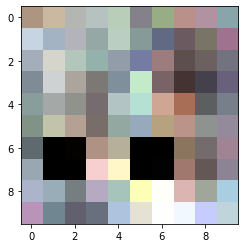

In [74]:
plt.imshow(Norma_Xpercentile(stack[5,:,:,]))

In [ ]:
os.removedirs('/home/jgovoort/patch')

In [ ]:
os.mkdir('./patch')

In [ ]:
os.path.join('home','jgovoort','patch') 

In [ ]:
path = '/home/jgovoort/Images/Sentinel1.jpeg'
if os.path.splitext(path)[1] != '.tiff' or os.path.splitext(path)[1] != '.tif':
    sys.exit("NOT ALLOWED")

In [ ]:
row = 'uygduhd,ddssdds,dsdsdsdsd,sddsszeez,dsdsd'
'|'.join(row.split(','))